# Modélisation site IKEA Plaisir

## 202 Rue Henri Barbusse, 78370 Plaisir

## ATTENTION : il faut toujours avant d'ouvrir le notebook mettre dans gitbash "conda activate pv_model_env"  ou sélectionner ce kernel

#### En ayant installer l'environnement au préalable
1. conda create --name pv_model_env python=3.10

2. conda activate pv_model_env

3. conda install -c conda-forge pvlib pandas geopandas jupyterlab

In [3]:
import pandas as pd
import geopandas as gpd
import pvlib
import matplotlib.pyplot as plt
import requests
import numpy as np

In [4]:
from geopandas.tools import geocode # faire "!pip install geopy" avant ;)

# coordonnées du site
adresse = "Av. Girard Madoux, 73800 Montmélian"
gdf_geocoded = geocode(adresse)
longitude = gdf_geocoded.geometry.iloc[0].x # 
latitude = gdf_geocoded.geometry.iloc[0].y # 
# altitude = 60 # en m
tz = 'Europe/Paris' # fuseau horaire

# période d'étude
start_date = "2023-01-01"
end_date = "2023-12-31"

In [5]:
print(latitude, longitude)

45.49896086320915 6.052783045007055


## On importe les données métérologiques

In [6]:
# URL Open-Meteo
openmeteo_url = "https://archive-api.open-meteo.com/v1/archive"

# Paramètres avec seulement les données météorologiques qui nous intéressent
params = {
    "latitude": latitude,
    "longitude": longitude,
    "start_date": start_date,
    "end_date": end_date,
    "timezone": "UTC",  # on récupère en UTC pour éviter les problèmes d'heure d'été/hiver
    "hourly": [
        "temperature_2m",           # température de l'air 
        "shortwave_radiation",      # GHI (Global Horizontal Irradiance, W/m²)
        "direct_normal_irradiance", # DNI (Direct Normal Irradiance, W/m²)
        "diffuse_radiation"         # DHI (Diffuse Horizontal Irradiance, W/m²)
    ]
}

response = requests.get(openmeteo_url, params=params)
data = response.json()
hourly_data = data['hourly']

# Création DataFrame des données météorologiques par heure
df_meteo = pd.DataFrame(hourly_data)
df_meteo['time'] = pd.to_datetime(df_meteo['time'])  # conversion en DateTime
df_meteo = df_meteo.set_index('time')  # index = date
df_meteo.index = df_meteo.index.tz_localize('UTC').tz_convert(tz)  # conversion fuseau horaire


# Changement noms des colonnes
df_meteo = df_meteo.rename(columns={
    "temperature_2m": "temp_air",
    "shortwave_radiation": "ghi",
    "direct_normal_irradiance": "dni",
    "diffuse_radiation": "dhi"
})

altitude = data['elevation']

In [7]:
df_meteo.index

DatetimeIndex(['2023-01-01 01:00:00+01:00', '2023-01-01 02:00:00+01:00',
               '2023-01-01 03:00:00+01:00', '2023-01-01 04:00:00+01:00',
               '2023-01-01 05:00:00+01:00', '2023-01-01 06:00:00+01:00',
               '2023-01-01 07:00:00+01:00', '2023-01-01 08:00:00+01:00',
               '2023-01-01 09:00:00+01:00', '2023-01-01 10:00:00+01:00',
               ...
               '2023-12-31 15:00:00+01:00', '2023-12-31 16:00:00+01:00',
               '2023-12-31 17:00:00+01:00', '2023-12-31 18:00:00+01:00',
               '2023-12-31 19:00:00+01:00', '2023-12-31 20:00:00+01:00',
               '2023-12-31 21:00:00+01:00', '2023-12-31 22:00:00+01:00',
               '2023-12-31 23:00:00+01:00', '2024-01-01 00:00:00+01:00'],
              dtype='datetime64[ns, Europe/Paris]', name='time', length=8760, freq=None)

ATTENTION : ne le faire qu'une fois pour supprimer 2024-01-01 00:00

In [8]:
df_meteo = df_meteo.iloc[:-1]

#### ATTENTION : seule méthode pour avoir l'altitude du site

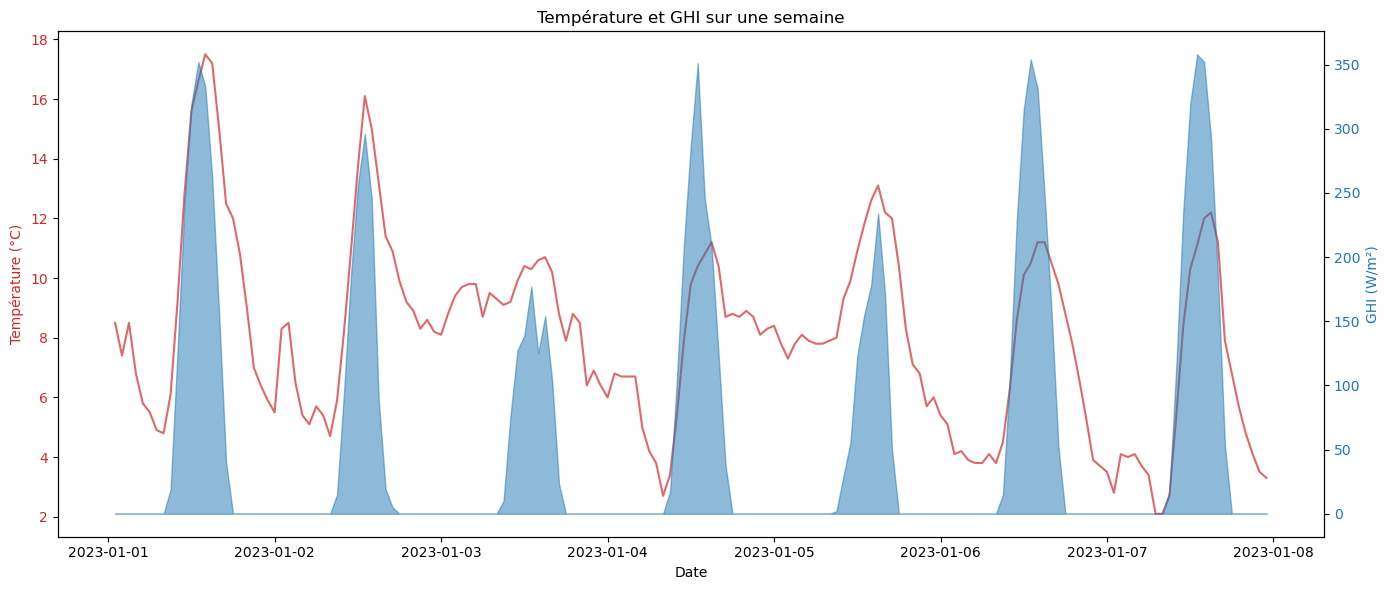

In [10]:
# Joli graphe grâce à Gemini

%matplotlib inline
df_meteo_sample = df_meteo.loc['2023-01-01':'2023-01-07']

fig, ax1 = plt.subplots(figsize=(14, 6))

# Axe 1 (Température)
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Température (°C)', color=color)
ax1.plot(df_meteo_sample.index, df_meteo_sample['temp_air'], color=color, alpha=0.7, label='Température')
ax1.tick_params(axis='y', labelcolor=color)

# Axe 2 (GHI)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('GHI (W/m²)', color=color)
ax2.fill_between(df_meteo_sample.index, 0, df_meteo_sample['ghi'], color=color, alpha=0.5, label='GHI (Ensoleillement)')
ax2.tick_params(axis='y', labelcolor=color)

# Titre ajusté
ax1.set_title("Température et GHI sur une semaine")
fig.tight_layout()
plt.show()

## Téléchargemnt des données BDTOPO (soit l'empreinte 2D au sol ou bien la modélisation 3D du bâtiment)
Pour ce faire, on va utiliser le site : https://data.geopf.fr/wfs/ows

Et on choisit le bâtiment avec la class BuildingSelectorNotebook !

## Localisation du bâtiment et acquisition GeoDataFrame associé

Avant : pip install contextily et pip install ipympl

⏳ Récupération des données IGN...
✅ 50 bâtiments chargés.


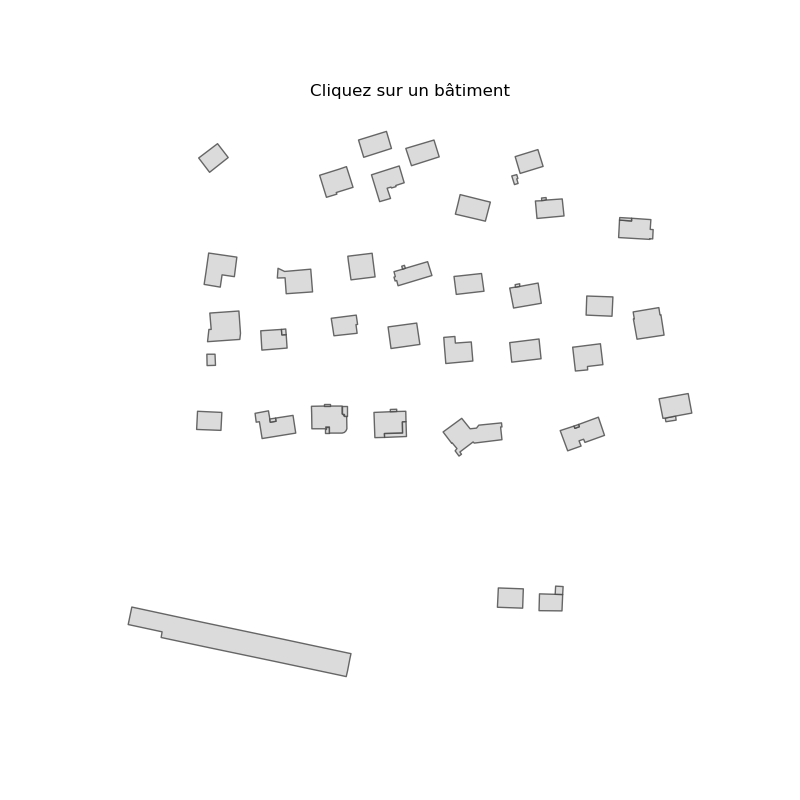

In [11]:
%matplotlib widget
import matplotlib.pyplot as plt
from selecteur import BuildingSelectorNotebook

plt.close('all')  # on nettoie

app = BuildingSelectorNotebook(lat=latitude, lon=longitude, side_length=200)

if app.fetch_data():  # Récupération et Affichage
    fig = app.create_map()
    
    # On affiche la figure
    fig

In [12]:
# Une fois le clic effectué sur la carte :
gdf_bat = app.selected_building

if gdf_bat is not None:
    print(f"Bâtiment récupéré (ID: {gdf_bat.iloc[0]['cleabs']})")
else:
    print("En attente de sélection...")

gdf_bat

Bâtiment récupéré (ID: BATIMENT0000000216580622)


,id,cleabs,nature,usage_1,usage_2,construction_legere,etat_de_l_objet,date_creation,date_modification,date_d_apparition,...,materiaux_de_la_toiture,hauteur,altitude_minimale_sol,altitude_minimale_toit,altitude_maximale_toit,altitude_maximale_sol,origine_du_batiment,appariement_fichiers_fonciers,identifiants_rnb,geometry
7,batiment.13187276,BATIMENT0000000216580622,Indifférenciée,Résidentiel,None,False,En service,2009-01-30 12:50:27.767000+00:00,2023-11-06 11:20:35.168000+00:00,1965-01-01,...,20,5.8,307.0,312.8,313.8,310.2,Cadastre,A 1.0,X2CMRRDR8S3Z,"MULTIPOLYGON Z (((938375.5 6493425.005 312.8, ..."


## Modélisation production des panneaux électriques

##### Données utiles pour modélisation et détermination de la production maximale

In [13]:
surface_au_sol = gdf_bat.geometry.area.item()  # en m²
    
encombrement_max = 0.4  # pourcentage classique d'encombrement à cause des ombres portés etc
surface_pv_max = surface_au_sol * encombrement_max
    
angle = 10 # en ° toit plat donc on prend l'inclinaison usuel des panneaux solaires  
azimuth = 180 # en ° on oriente les panneaux solaires plein Sud (ce qui est le plus optimal)

print(f"Surface maximale de panneaux solaires : {surface_pv_max:.0f} m²")

Surface maximale de panneaux solaires : 83 m²


In [11]:
location = pvlib.location.Location(latitude=latitude, longitude=longitude, altitude=altitude, tz=tz)

# Choix du module, de l'onduleur, du modèle de température du panneau solaire (inclinaison, température de l'air, ensoleillement)
module = pvlib.pvsystem.retrieve_sam('CECMod')['Canadian_Solar_Inc__CS6K_280M']
inverter = pvlib.pvsystem.retrieve_sam('CECInverter')['SMA_America__SB5000TL_US_22__240V_']
temperature_params = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

system = pvlib.pvsystem.PVSystem(
    module_parameters=module,
    inverter_parameters=inverter,
    surface_tilt=angle,
    surface_azimuth=azimuth,
    temperature_model_parameters=temperature_params,
    modules_per_string=1,  # 1 module en série
    strings_per_inverter=1)  # 1 seule mise en parralèle
# rq : on le fait pour UN module pour calculer la production électrique pour un seul module

# On run le ModelChain pour 1 module sur un an de météo
mc = pvlib.modelchain.ModelChain(system, location, aoi_model='ashrae')  # 
mc.run_model(df_meteo) # où df_meteo doit contenir ghi, dni, dhi et temp_air

# Production du module de base (en W) pour chaque heure
production_module_w = mc.results.ac.fillna(0)  # ac calcul la production en courant alternatif (AC)

# Production du site (en W) par m²
surface_module = module['Length'] * module['Width']
production_site_w_par_m2 = production_module_w / surface_module 

# Production totale du site (en W) pour chaque heure
production_totale_max_w = production_site_w_par_m2 * surface_pv_max

# Calcul de la production annuelle totale (en kWh)
production_annuelle_max_kwh = (production_totale_max_w).sum() / 1000  # ici on somme les puissances avec un pas de temps de 1h donc on obtient des kWh

print(f"{float(production_annuelle_max_kwh):.0f}") # soit 1,1 GWh ce qui est cohérent

631447


c:\miniconda\envs\pv_model_env\lib\site-packages\scipy\optimize\_chandrupatla.py:438: RuntimeWarning: invalid value encountered in divide
  C = A / (A + B)


## Téléchargement des données de consommation électrique d'un bâtiment-type

#### Pour cette étape, on aura jamais accès aux données réelles, on va donc toujours faire soit des hypothèses, soit prendre un jeu de données d'endis type (maison, immeubles, etc)

https://portail.agenceore.fr/pages/explore

https://data.enedis.fr/explore/dataset

On télécharge les données de Yassine du cloud : https://cloud.minesparis.psl.eu/index.php/s/mh71LuOLKB8PwgM

##### ATTENTION il faut avant faire : !pip install pandas pyarrow

In [15]:
chemin_conso_sup36_region = 'conso-sup36-region.parquet'

# On crée le DataFrame de la consommation en Wh, on souhaite avoir uniquement celle du tertiaire
df_conso_wh = pd.read_parquet(chemin_conso_sup36_region)

df_conso_wh['horodate'] = pd.to_datetime(df_conso_wh['horodate']).dt.tz_convert(tz)  # conversion en DateTime qu'on calibre au bon fuseau horaire

# On sélectionne le secteur tertiaire, une plage de puissance élevée (P5) et le profil correspondant aux entreprises de bureaux/commerces (ENT1 (+ ENT2))
conso_wh_tertiaire_P5_profil = (df_conso_wh['secteur_activite'] == 'S3: Tertiaire') & (df_conso_wh['plage_de_puissance_souscrite'] == 'P5: ]1000-2000] kVA') & (df_conso_wh['profil'] == 'ENT1 (+ ENT2)')
df_conso_wh = df_conso_wh[conso_wh_tertiaire_P5_profil]

# On ne garde que la colonne 'courbe_moyenne_ndeg1_ndeg2_wh' qui nous intéresse
df_conso_wh = df_conso_wh[['region', 'courbe_moyenne_ndeg1_ndeg2_wh', 'horodate']]

# On somme les consommations de toutes les régions
df_conso_wh = df_conso_wh.groupby('horodate')['courbe_moyenne_ndeg1_ndeg2_wh'].sum().rename('courbe_moyenne_ndeg1_ndeg2_wh')

# df_conso_wh.sort_index(inplace=True)  # on trie
df_conso_wh= df_conso_wh[df_conso_wh.index.year == 2023]  # on ne garde que 2023

# Convertion de la consommation en numérique (float) puis on met NaN pour les valeurs non convertibles
df_conso_wh = pd.to_numeric(df_conso_wh, errors='coerce')

# Suppression des lignes avec consommation NaN
df_conso_wh = df_conso_wh.dropna()

## Profil de consommation du site 

In [16]:
df_conso_wh = df_conso_wh.resample('1h').mean()  # on veut conso heure par heure

df_conso_wh_std = df_conso_wh / df_conso_wh.sum()  # profil normalisé pour secteur tertiaire

# ! Hypothèse très très forte ! (mais celle trouvée sur internet)
conso_m2_an = 160  # kWh/m²/an

conso_wh_total = df_conso_wh_std * surface_au_sol * conso_m2_an * 1000  # on convertit en Wh

# Calcul de la consommation annuelle totale (en kWh)
consommation_annuelle_kwh = (conso_wh_total).sum() / 1000  # ici on somme les puissances avec un pas de temps de 1h donc on obtient des kWh

print(f"{float(consommation_annuelle_kwh):.0f}") # soit 3 Gwh (ce qui n'est pas cohérent)

1480190


In [17]:
conso_wh_total.index

DatetimeIndex(['2023-01-01 00:00:00+01:00', '2023-01-01 01:00:00+01:00',
               '2023-01-01 02:00:00+01:00', '2023-01-01 03:00:00+01:00',
               '2023-01-01 04:00:00+01:00', '2023-01-01 05:00:00+01:00',
               '2023-01-01 06:00:00+01:00', '2023-01-01 07:00:00+01:00',
               '2023-01-01 08:00:00+01:00', '2023-01-01 09:00:00+01:00',
               ...
               '2023-12-31 14:00:00+01:00', '2023-12-31 15:00:00+01:00',
               '2023-12-31 16:00:00+01:00', '2023-12-31 17:00:00+01:00',
               '2023-12-31 18:00:00+01:00', '2023-12-31 19:00:00+01:00',
               '2023-12-31 20:00:00+01:00', '2023-12-31 21:00:00+01:00',
               '2023-12-31 22:00:00+01:00', '2023-12-31 23:00:00+01:00'],
              dtype='datetime64[ms, Europe/Paris]', name='horodate', length=8760, freq='h')

ATTENTION : ne le faire qu'une fois pour enlever 2023-01-01 00:01

In [18]:
conso_wh_total = conso_wh_total.iloc[1:]

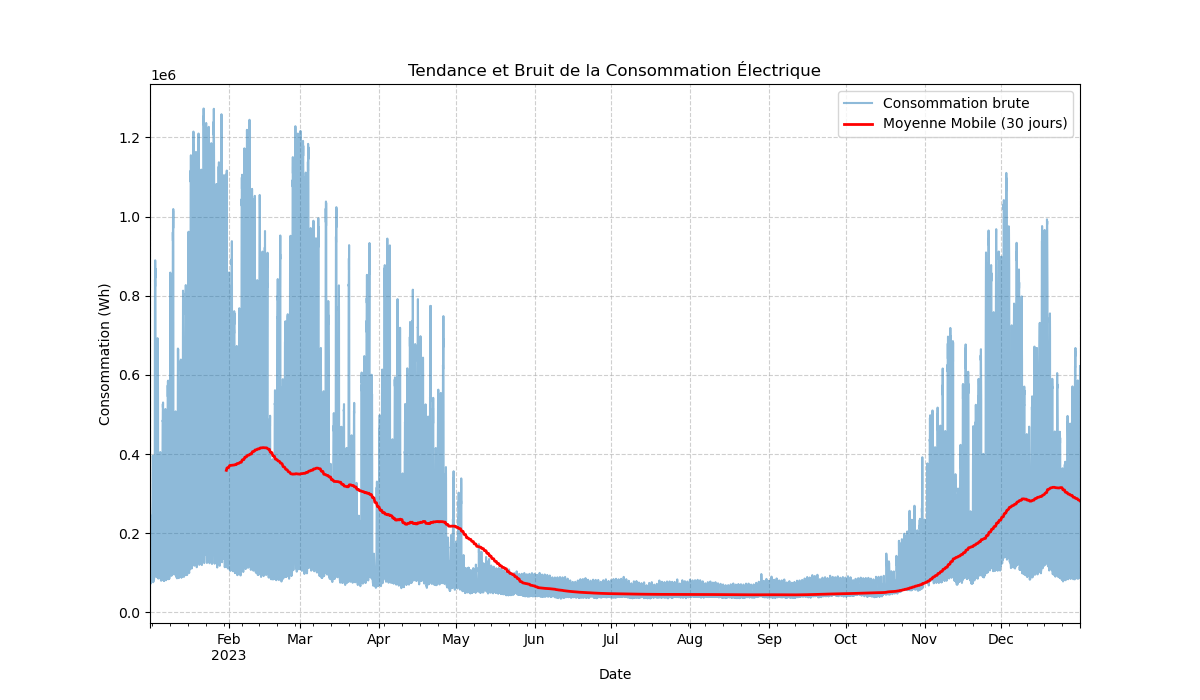

In [19]:
# Moyenne mobile sur 30 jours (720 heures pour des données horaires) (graphe Gemini)
df_moving_avg = conso_wh_total.rolling(window=720).mean()

plt.figure(figsize=(12, 7))
conso_wh_total.plot(alpha=0.5, label='Consommation brute')
df_moving_avg.plot(color='red', linewidth=2, label='Moyenne Mobile (30 jours)')
plt.xlim(conso_wh_total.index.min(), conso_wh_total.index.max())

plt.title('Tendance et Bruit de la Consommation Électrique')
plt.xlabel('Date')
plt.ylabel('Consommation (Wh)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Rentabilité du projet

Surface recommandée : 1350 m²
Coût total sur 20 ans : 5,986,758 €
Économie vs pas de panneaux : 375,902.04 €


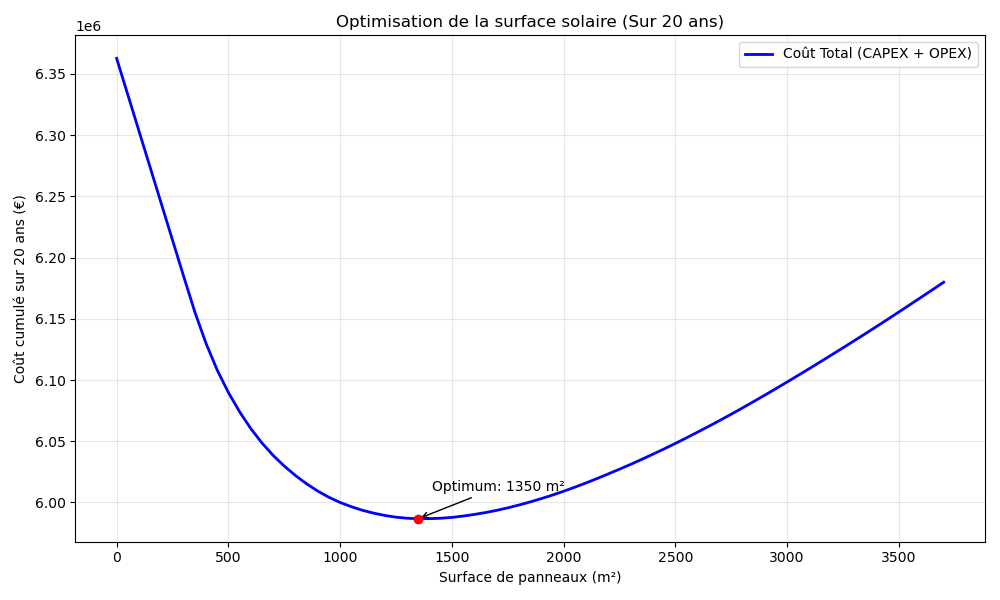

In [20]:
# Configuration et hypothèses financières
duree_projet = 20               # ans
prix_achat_elec = 0.16          # €/kWh (prix initial import réseau)
prix_vente_surplus = 0          # €/kWh (tarif rachat injection)
cout_installation = 140         # €/m² (panneaux + onduleurs + pose)
inflation_elec = 0.03           # 3% d'augmentation par an du prix de l'électricité
# taux_actualisation = 0.99       # malus de 1% par an sur l'investissement initial


def calculer_cout_total(surface_panneaux, df_conso, df_prod_std):
    """
    Calcule le bilan financier sur 20 ans pour une surface donnée.
    """
    # 1. Investissement initial (CAPEX)
    capex = surface_panneaux * cout_installation
    
    # 2. Calcul des flux énergétiques annuels
    df_prod_tot = df_prod_std * surface_panneaux
    
    # Bilan heure par heure : Production - Consommation
    bilan = df_prod_tot - df_conso

    # Si bilan > 0 : Surplus (Vente)
    # Si bilan < 0 : Déficit (Achat réseau)
    surplus = np.maximum(bilan, 0)
    deficit = np.abs(np.minimum(bilan, 0)) # On prend la valeur absolue
    
    # 3. Projection sur 20 ans (OPEX)
    cout_exploitation_total = 0
    
    # On itère sur les années pour appliquer l'inflation
    prix_achat_actuel = prix_achat_elec
    
    # Somme annuelle (base)
    kwh_achetes_an = deficit.sum() / 1000  # en kWh
    kwh_vendus_an = surplus.sum()  / 1000  # en kWh

    
    for annee in range(duree_projet):
        cout_achat = kwh_achetes_an * prix_achat_actuel
        revenu_vente = kwh_vendus_an * prix_vente_surplus
        flux_annuel = cout_achat - revenu_vente

        cout_exploitation_total += flux_annuel
        
        # Application de l'inflation pour l'année suivante
        prix_achat_actuel *= (1 + inflation_elec)

    return (capex + cout_exploitation_total)

# Optimisation
# On teste des surfaces de 0 à surface_pv_max par pas de 50m²
surfaces_a_tester = np.arange(0, surface_pv_max + 1, 50)
resultats = []

for s in surfaces_a_tester:
    cout = calculer_cout_total(s, conso_wh_total, production_site_w_par_m2)
    resultats.append(cout)

# Création d'un DataFrame de résultats
df_res = pd.DataFrame({'surface_m2': surfaces_a_tester, 'cout_total_20ans': resultats})

# On trouve l'optimum
optimum = df_res.loc[df_res['cout_total_20ans'].idxmin()]

print(f"Surface recommandée : {optimum['surface_m2']:.0f} m²")
print(f"Coût total sur 20 ans : {optimum['cout_total_20ans']:,.0f} €")
print(f"Économie vs pas de panneaux : {(resultats[0] - optimum['cout_total_20ans']):,.2f} €")

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(df_res['surface_m2'], df_res['cout_total_20ans'], label='Coût Total (CAPEX + OPEX)', color='blue', linewidth=2)

# Mise en évidence de l'optimum
plt.scatter(optimum['surface_m2'], optimum['cout_total_20ans'], color='red', zorder=5)
plt.annotate(f"Optimum: {optimum['surface_m2']:.0f} m²", 
             (optimum['surface_m2'], optimum['cout_total_20ans']), 
             xytext=(10, 20), textcoords='offset points', arrowprops=dict(arrowstyle="->"))

plt.title(f"Optimisation de la surface solaire (Sur {duree_projet} ans)")
plt.xlabel("Surface de panneaux (m²)")
plt.ylabel("Coût cumulé sur 20 ans (€)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


On remarque qu'il est rentable de couvrir entièrement le toît de panneaux solaires !